In [27]:
import argparse
import os
import shutil
import sys
import time
import warnings
from random import sample

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt

In [28]:
from cgcnn.data import CIFData
from cgcnn.data import collate_pool, get_train_val_test_loader
from cgcnn.model import CrystalGraphConvNet
torch.cuda.set_device(1)

In [29]:
parser = argparse.ArgumentParser(description='Crystal Graph Convolutional Neural Networks')
parser.add_argument('data_options', metavar='OPTIONS', nargs='+',
                    help='dataset options, started with the path to root dir, '
                         'then other options')
parser.add_argument('--task', choices=['regression', 'classification'],
                    default='regression', help='complete a regression or '
                                                   'classification task (default: regression)')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('-j', '--workers', default=0, type=int, metavar='N',
                    help='number of data loading workers (default: 0)')
parser.add_argument('--epochs', default=300, type=int, metavar='N',
                    help='number of total epochs to run (default: 30)')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=100, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.01, type=float,
                    metavar='LR', help='initial learning rate (default: '
                                       '0.01)')
parser.add_argument('--lr-milestones', default=[100], nargs='+', type=int,
                    metavar='N', help='milestones for scheduler (default: '
                                      '[100])')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=0, type=float,
                    metavar='W', help='weight decay (default: 0)')
parser.add_argument('--print-freq', '-p', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
train_group = parser.add_mutually_exclusive_group()
train_group.add_argument('--train-ratio', default=0.8, type=float, metavar='N',
                    help='number of training data to be loaded (default none)')
train_group.add_argument('--train-size', default=None, type=int, metavar='N',
                         help='number of training data to be loaded (default none)')
valid_group = parser.add_mutually_exclusive_group()
valid_group.add_argument('--val-ratio', default=0.1, type=float, metavar='N',
                    help='percentage of validation data to be loaded (default '
                         '0.1)')
valid_group.add_argument('--val-size', default=None, type=int, metavar='N',
                         help='number of validation data to be loaded (default '
                              '1000)')
test_group = parser.add_mutually_exclusive_group()
test_group.add_argument('--test-ratio', default=0.1, type=float, metavar='N',
                    help='percentage of test data to be loaded (default 0.1)')
test_group.add_argument('--test-size', default=None, type=int, metavar='N',
                        help='number of test data to be loaded (default 1000)')

parser.add_argument('--optim', default='Adam', type=str, metavar='SGD',
                    help='choose an optimizer, SGD or Adam, (default: SGD)')
parser.add_argument('--atom-fea-len', default=64, type=int, metavar='N',
                    help='number of hidden atom features in conv layers')
parser.add_argument('--h-fea-len', default=64, type=int, metavar='N',
                    help='number of hidden features after pooling')
parser.add_argument('--n-conv', default=3, type=int, metavar='N',
                    help='number of conv layers')
parser.add_argument('--n-h', default=2, type=int, metavar='N',
                    help='number of hidden layers after pooling')

_StoreAction(option_strings=['--n-h'], dest='n_h', nargs=None, const=None, default=2, type=<class 'int'>, choices=None, help='number of hidden layers after pooling', metavar='N')

In [30]:
args = parser.parse_args(['data/Ag_Pd_root'])

In [31]:
args.cuda = not args.disable_cuda and torch.cuda.is_available()

if args.task == 'regression':
    best_mae_error = 1e10
else:
    best_mae_error = 0.

In [32]:
def run():
    global args, best_mae_error

    # load data
    dataset = CIFData('data/Ag_Pd_root',radius = 12,max_num_nbr = 24)
    collate_fn = collate_pool
    train_loader, val_loader, test_loader = get_train_val_test_loader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=args.batch_size,
        train_ratio=args.train_ratio,
        num_workers=args.workers,
        val_ratio=args.val_ratio,
        test_ratio=args.test_ratio,
        pin_memory=args.cuda,
        train_size=args.train_size,
        val_size=args.val_size,
        test_size=args.test_size,
        return_test=True)

    # obtain target value normalizer
    if args.task == 'classification':
        normalizer = Normalizer(torch.zeros(2))
        normalizer.load_state_dict({'mean': 0., 'std': 1.})
    else:
        if len(dataset) < 500:
            warnings.warn('Dataset has less than 500 data points. '
                          'Lower accuracy is expected. ')
            sample_data_list = [dataset[i] for i in range(len(dataset))]
        else:
            sample_data_list = [dataset[i] for i in
                                sample(range(len(dataset)), 500)]
        _, sample_target, _ = collate_pool(sample_data_list)
        normalizer = Normalizer(sample_target)

    # build model
    structures, _, _ = dataset[0]
    orig_atom_fea_len = structures[0].shape[-1]
    nbr_fea_len = structures[1].shape[-1]
    model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                                atom_fea_len=args.atom_fea_len,
                                n_conv=args.n_conv,
                                h_fea_len=args.h_fea_len,
                                n_h=args.n_h,
                                classification=True if args.task ==
                                                       'classification' else False)
    if args.cuda:
        model.cuda()

    # define loss func and optimizer
    if args.task == 'classification':
        criterion = nn.NLLLoss()
    else:
        criterion = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), args.lr,
                              momentum=args.momentum,
                              weight_decay=args.weight_decay)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), args.lr,
                               weight_decay=args.weight_decay)
    else:
        raise NameError('Only SGD or Adam is allowed as --optim')

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            best_mae_error = checkpoint['best_mae_error']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            normalizer.load_state_dict(checkpoint['normalizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    scheduler = MultiStepLR(optimizer, milestones=args.lr_milestones,
                            gamma=0.1)

    for epoch in range(args.start_epoch, args.epochs):
        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, normalizer)

        # evaluate on validation set
        mae_error = validate(epoch,val_loader, model, criterion, normalizer)

        if mae_error != mae_error:
            print('Exit due to NaN')
            sys.exit(1)

        scheduler.step()

        # remember the best mae_eror and save checkpoint
        if args.task == 'regression':
            is_best = mae_error < best_mae_error
            best_mae_error = min(mae_error, best_mae_error)
        else:
            is_best = mae_error > best_mae_error
            best_mae_error = max(mae_error, best_mae_error)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_mae_error': best_mae_error,
            'optimizer': optimizer.state_dict(),
            'normalizer': normalizer.state_dict(),
            'args': vars(args)
        }, is_best)

    # test best model
    print('---------Evaluate Model on Test Set---------------')
    best_checkpoint = torch.load('model_final_submission.pth.tar')
    model.load_state_dict(best_checkpoint['state_dict'])
    validate(epoch,test_loader, model, criterion, normalizer, test=True)
    return epoch,test_loader, model, criterion, normalizer

In [33]:
def train(train_loader, model, criterion, optimizer, epoch, normalizer):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    if args.task == 'regression':
        mae_errors = AverageMeter()
    else:
        accuracies = AverageMeter()
        precisions = AverageMeter()
        recalls = AverageMeter()
        fscores = AverageMeter()
        auc_scores = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target, _) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if args.cuda:
            input_var = (Variable(input[0].cuda(non_blocking=True)),
                         Variable(input[1].cuda(non_blocking=True)),
                         input[2].cuda(non_blocking=True),
                         [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]])
        else:
            input_var = (Variable(input[0]),
                         Variable(input[1]),
                         input[2],
                         input[3])
        # normalize target
        if args.task == 'regression':
            target_normed = normalizer.norm(target)
        else:
            target_normed = target.view(-1).long()
        if args.cuda:
            target_var = Variable(target_normed.cuda(non_blocking=True))
        else:
            target_var = Variable(target_normed)

        # compute output
        output = model(*input_var)
        loss = get_loss(input_var[0],input_var[3],output, target_var,epoch,normalizer)
        #loss = mae(normalizer.denorm(output), target)
        # measure accuracy and record loss
        if args.task == 'regression':
            mae_error = mae(normalizer.denorm(output.data.cpu()), target)
            losses.update(loss.data.cpu(), target.size(0))
            mae_errors.update(mae_error, target.size(0))
        else:
            accuracy, precision, recall, fscore, auc_score = \
                class_eval(output.data.cpu(), target)
            losses.update(loss.data.cpu().item(), target.size(0))
            accuracies.update(accuracy, target.size(0))
            precisions.update(precision, target.size(0))
            recalls.update(recall, target.size(0))
            fscores.update(fscore, target.size(0))
            auc_scores.update(auc_score, target.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            if args.task == 'regression':
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                    epoch, i, len(train_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses, mae_errors=mae_errors)
                )
            else:
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Accu {accu.val:.3f} ({accu.avg:.3f})\t'
                      'Precision {prec.val:.3f} ({prec.avg:.3f})\t'
                      'Recall {recall.val:.3f} ({recall.avg:.3f})\t'
                      'F1 {f1.val:.3f} ({f1.avg:.3f})\t'
                      'AUC {auc.val:.3f} ({auc.avg:.3f})'.format(
                    epoch, i, len(train_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses, accu=accuracies,
                    prec=precisions, recall=recalls, f1=fscores,
                    auc=auc_scores)
                )

In [34]:
def get_loss(labels,crystals,out,targ,epoch,normalizer):
    #temp = 0.5 - 0.495*(epoch/100)
    
    #print(weights)
    #loss = torch.abs(out-targ).view(-1)*weights.view(-1)
    loss = torch.abs(out-targ).view(-1)
    return loss.mean()

In [35]:
def validate(epoch,val_loader, model, criterion, normalizer, test=False):
    batch_time = AverageMeter()
    losses = AverageMeter()
    if args.task == 'regression':
        mae_errors = AverageMeter()
    else:
        accuracies = AverageMeter()
        precisions = AverageMeter()
        recalls = AverageMeter()
        fscores = AverageMeter()
        auc_scores = AverageMeter()
    if test:
        test_targets = []
        test_preds = []
        test_cif_ids = []

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target, batch_cif_ids) in enumerate(val_loader):
        if args.cuda:
            with torch.no_grad():
                input_var = (Variable(input[0].cuda(non_blocking=True)),
                             Variable(input[1].cuda(non_blocking=True)),
                             input[2].cuda(non_blocking=True),
                             [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]])
        else:
            with torch.no_grad():
                input_var = (Variable(input[0]),
                             Variable(input[1]),
                             input[2],
                             input[3])
        if args.task == 'regression':
            target_normed = normalizer.norm(target)
        else:
            target_normed = target.view(-1).long()
        if args.cuda:
            with torch.no_grad():
                target_var = Variable(target_normed.cuda(non_blocking=True))
        else:
            with torch.no_grad():
                target_var = Variable(target_normed)

        # compute output
        output = model(*input_var)
        #loss = get_loss(input_var[0],input_var[3],output, target_var,epoch,normalizer)
        loss = mae(normalizer.denorm(output.data.cpu()), target)
        
        # measure accuracy and record loss
        if args.task == 'regression':
            
            #mae_error = mae(normalizer.denorm(output.data.cpu()), target)
            mae_error = loss
            losses.update(loss.data.cpu().item(), target.size(0))
            mae_errors.update(mae_error, target.size(0))
            plt.scatter(normalizer.denorm(output.data.cpu()),target)
            #import matplotlib as mpl
            #mpl.rc('font',family='Arial')
            #hfont = {'fontname':'Arial'}
            #plt.xlabel('Predicted (ev/atom)',fontsize=14,**hfont)
            
            #plt.ylabel('Actual (ev/atom)',fontsize=14,**hfont)
            #plt.xticks(fontsize = 14,fontname = "Arial") 
            #plt.yticks(fontsize = 14,fontname = "Arial") 
            #plt.xlim(-0.065,0.01)
            #plt.ylim(-0.065,0.01)
            #x = np.linspace(-0.065,0.01,200)
            #plt.plot(x,x,'r--')
            #plt.xticks([-0.06,-0.04,-0.02,0.0])
            #plt.yticks([-0.06,-0.04,-0.02,0.0])
            #plt.savefig('CGC_test.pdf',bbox_inches='tight')
            #plt.show()
            if test:
                test_pred = normalizer.denorm(output.data.cpu())
                test_target = target
                test_preds += test_pred.view(-1).tolist()
                test_targets += test_target.view(-1).tolist()
                test_cif_ids += batch_cif_ids
        else:
            accuracy, precision, recall, fscore, auc_score = \
                class_eval(output.data.cpu(), target)
            losses.update(loss.data.cpu().item(), target.size(0))
            accuracies.update(accuracy, target.size(0))
            precisions.update(precision, target.size(0))
            recalls.update(recall, target.size(0))
            fscores.update(fscore, target.size(0))
            auc_scores.update(auc_score, target.size(0))
            if test:
                test_pred = torch.exp(output.data.cpu())
                test_target = target
                assert test_pred.shape[1] == 2
                test_preds += test_pred[:, 1].tolist()
                test_targets += test_target.view(-1).tolist()
                test_cif_ids += batch_cif_ids

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            if args.task == 'regression':
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    mae_errors=mae_errors))
            else:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Accu {accu.val:.3f} ({accu.avg:.3f})\t'
                      'Precision {prec.val:.3f} ({prec.avg:.3f})\t'
                      'Recall {recall.val:.3f} ({recall.avg:.3f})\t'
                      'F1 {f1.val:.3f} ({f1.avg:.3f})\t'
                      'AUC {auc.val:.3f} ({auc.avg:.3f})'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    accu=accuracies, prec=precisions, recall=recalls,
                    f1=fscores, auc=auc_scores))

    if test:
        star_label = '**'
        import csv
        with open('test_results_final_submission.csv', 'w') as f:
            writer = csv.writer(f)
            for cif_id, target, pred in zip(test_cif_ids, test_targets,
                                            test_preds):
                writer.writerow((cif_id, target, pred))
    else:
        star_label = '*'
    if args.task == 'regression':
        print(' {star} MAE {mae_errors.avg:.3f}'.format(star=star_label,
                                                        mae_errors=mae_errors))
        return mae_errors.avg
    else:
        print(' {star} AUC {auc.avg:.3f}'.format(star=star_label,
                                                 auc=auc_scores))
        return auc_scores.avg


In [36]:
class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [37]:
def mae(prediction, target):
    """
    Computes the mean absolute error between prediction and target

    Parameters
    ----------

    prediction: torch.Tensor (N, 1)
    target: torch.Tensor (N, 1)
    """
    return torch.mean(torch.abs(target - prediction)*1000)

In [38]:
def class_eval(prediction, target):
    prediction = np.exp(prediction.numpy())
    target = target.numpy()
    pred_label = np.argmax(prediction, axis=1)
    target_label = np.squeeze(target)
    if not target_label.shape:
        target_label = np.asarray([target_label])
    if prediction.shape[1] == 2:
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
            target_label, pred_label, average='binary')
        auc_score = metrics.roc_auc_score(target_label, prediction[:, 1])
        accuracy = metrics.accuracy_score(target_label, pred_label)
    else:
        raise NotImplementedError
    return accuracy, precision, recall, fscore, auc_score


In [39]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, filename='checkpoint_final_submission.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_final_submission.pth.tar')


def adjust_learning_rate(optimizer, epoch, k):
    """Sets the learning rate to the initial LR decayed by 10 every k epochs"""
    assert type(k) is int
    lr = args.lr * (0.1 ** (epoch // k))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

/home/james/miniconda3/envs/james_mlmat/lib/python3.7/site-packages/pymatgen/io/cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Epoch: [0][0/5]	Time 0.727 (0.727)	Data 0.532 (0.532)	Loss 0.8141 (0.8141)	MAE 12.107 (12.107)
Test: [0/1]	Time 0.557 (0.557)	Loss 35.9937 (35.9937)	MAE 35.994 (35.994)
 * MAE 35.994
Epoch: [1][0/5]	Time 0.095 (0.095)	Data 0.007 (0.007)	Loss 0.6372 (0.6372)	MAE 9.476 (9.476)
Test: [0/1]	Time 0.029 (0.029)	Loss 45.7330 (45.7330)	MAE 45.733 (45.733)
 * MAE 45.733
Epoch: [2][0/5]	Time 0.148 (0.148)	Data 0.014 (0.014)	Loss 0.3573 (0.3573)	MAE 5.314 (5.314)
Test: [0/1]	Time 0.016 (0.016)	Loss 27.4397 (27.4397)	MAE 27.440 (27.440)
 * MAE 27.440
Epoch: [3][0/5]	Time 0.096 (0.096)	Data 0.005 (0.005)	Loss 0.2659 (0.2659)	MAE 3.955 (3.955)
Test: [0/1]	Time 0.017 (0.017)	Loss 23.1569 (23.1569)	MAE 23.157 (23.157)
 * MAE 23.157
Epoch: [4][0/5]	Time 0.076 (0.076)	Data 0.007 (0.007)	Loss 0.3048 (0.3048)	MAE 4.533 (4.533)
Test: [0/1]	Time 0.043 (0.043)	Loss 35.6017 (35.6017)	MAE 35.602 (35.602)
 * MAE 35.602
Epoch: [5][0/5]	Time 0.178 (0.178)	Data 0.017 (0.017)	Loss 0.2558 (0.2558)	MAE 3.804 (3.804)


Test: [0/1]	Time 0.022 (0.022)	Loss 2.3829 (2.3829)	MAE 2.383 (2.383)
 * MAE 2.383
Epoch: [47][0/5]	Time 0.091 (0.091)	Data 0.012 (0.012)	Loss 0.1336 (0.1336)	MAE 1.987 (1.987)
Test: [0/1]	Time 0.013 (0.013)	Loss 8.1230 (8.1230)	MAE 8.123 (8.123)
 * MAE 8.123
Epoch: [48][0/5]	Time 0.068 (0.068)	Data 0.005 (0.005)	Loss 0.1602 (0.1602)	MAE 2.383 (2.383)
Test: [0/1]	Time 0.013 (0.013)	Loss 5.7516 (5.7516)	MAE 5.752 (5.752)
 * MAE 5.752
Epoch: [49][0/5]	Time 0.068 (0.068)	Data 0.005 (0.005)	Loss 0.1500 (0.1500)	MAE 2.230 (2.230)
Test: [0/1]	Time 0.013 (0.013)	Loss 4.7539 (4.7539)	MAE 4.754 (4.754)
 * MAE 4.754
Epoch: [50][0/5]	Time 0.107 (0.107)	Data 0.005 (0.005)	Loss 0.2061 (0.2061)	MAE 3.065 (3.065)
Test: [0/1]	Time 0.032 (0.032)	Loss 2.7608 (2.7608)	MAE 2.761 (2.761)
 * MAE 2.761
Epoch: [51][0/5]	Time 0.168 (0.168)	Data 0.017 (0.017)	Loss 0.1983 (0.1983)	MAE 2.949 (2.949)
Test: [0/1]	Time 0.014 (0.014)	Loss 5.7939 (5.7939)	MAE 5.794 (5.794)
 * MAE 5.794
Epoch: [52][0/5]	Time 0.103 (0.1

Test: [0/1]	Time 0.011 (0.011)	Loss 3.4853 (3.4853)	MAE 3.485 (3.485)
 * MAE 3.485
Epoch: [94][0/5]	Time 0.096 (0.096)	Data 0.004 (0.004)	Loss 0.2802 (0.2802)	MAE 4.167 (4.167)
Test: [0/1]	Time 0.013 (0.013)	Loss 5.2480 (5.2480)	MAE 5.248 (5.248)
 * MAE 5.248
Epoch: [95][0/5]	Time 0.071 (0.071)	Data 0.006 (0.006)	Loss 0.1628 (0.1628)	MAE 2.420 (2.420)
Test: [0/1]	Time 0.017 (0.017)	Loss 4.7424 (4.7424)	MAE 4.742 (4.742)
 * MAE 4.742
Epoch: [96][0/5]	Time 0.097 (0.097)	Data 0.005 (0.005)	Loss 0.1814 (0.1814)	MAE 2.698 (2.698)
Test: [0/1]	Time 0.012 (0.012)	Loss 4.1124 (4.1124)	MAE 4.112 (4.112)
 * MAE 4.112
Epoch: [97][0/5]	Time 0.089 (0.089)	Data 0.004 (0.004)	Loss 0.1994 (0.1994)	MAE 2.965 (2.965)
Test: [0/1]	Time 0.013 (0.013)	Loss 3.8446 (3.8446)	MAE 3.845 (3.845)
 * MAE 3.845
Epoch: [98][0/5]	Time 0.109 (0.109)	Data 0.005 (0.005)	Loss 0.1927 (0.1927)	MAE 2.866 (2.866)
Test: [0/1]	Time 0.014 (0.014)	Loss 8.0774 (8.0774)	MAE 8.077 (8.077)
 * MAE 8.077
Epoch: [99][0/5]	Time 0.099 (0.0

Test: [0/1]	Time 0.015 (0.015)	Loss 1.7278 (1.7278)	MAE 1.728 (1.728)
 * MAE 1.728
Epoch: [141][0/5]	Time 0.197 (0.197)	Data 0.006 (0.006)	Loss 0.0983 (0.0983)	MAE 1.461 (1.461)
Test: [0/1]	Time 0.041 (0.041)	Loss 1.7041 (1.7041)	MAE 1.704 (1.704)
 * MAE 1.704
Epoch: [142][0/5]	Time 0.128 (0.128)	Data 0.014 (0.014)	Loss 0.0981 (0.0981)	MAE 1.458 (1.458)
Test: [0/1]	Time 0.010 (0.010)	Loss 1.7739 (1.7739)	MAE 1.774 (1.774)
 * MAE 1.774
Epoch: [143][0/5]	Time 0.091 (0.091)	Data 0.004 (0.004)	Loss 0.1280 (0.1280)	MAE 1.904 (1.904)
Test: [0/1]	Time 0.010 (0.010)	Loss 1.7823 (1.7823)	MAE 1.782 (1.782)
 * MAE 1.782
Epoch: [144][0/5]	Time 0.121 (0.121)	Data 0.004 (0.004)	Loss 0.1475 (0.1475)	MAE 2.193 (2.193)
Test: [0/1]	Time 0.012 (0.012)	Loss 1.8043 (1.8043)	MAE 1.804 (1.804)
 * MAE 1.804
Epoch: [145][0/5]	Time 0.068 (0.068)	Data 0.004 (0.004)	Loss 0.1129 (0.1129)	MAE 1.679 (1.679)
Test: [0/1]	Time 0.013 (0.013)	Loss 1.9313 (1.9313)	MAE 1.931 (1.931)
 * MAE 1.931
Epoch: [146][0/5]	Time 0.05

Test: [0/1]	Time 0.013 (0.013)	Loss 1.5848 (1.5848)	MAE 1.585 (1.585)
 * MAE 1.585
Epoch: [188][0/5]	Time 0.098 (0.098)	Data 0.005 (0.005)	Loss 0.1485 (0.1485)	MAE 2.209 (2.209)
Test: [0/1]	Time 0.014 (0.014)	Loss 1.6307 (1.6307)	MAE 1.631 (1.631)
 * MAE 1.631
Epoch: [189][0/5]	Time 0.106 (0.106)	Data 0.006 (0.006)	Loss 0.1501 (0.1501)	MAE 2.232 (2.232)
Test: [0/1]	Time 0.026 (0.026)	Loss 1.9286 (1.9286)	MAE 1.929 (1.929)
 * MAE 1.929
Epoch: [190][0/5]	Time 0.130 (0.130)	Data 0.006 (0.006)	Loss 0.0988 (0.0988)	MAE 1.469 (1.469)
Test: [0/1]	Time 0.028 (0.028)	Loss 1.8502 (1.8502)	MAE 1.850 (1.850)
 * MAE 1.850
Epoch: [191][0/5]	Time 0.110 (0.110)	Data 0.006 (0.006)	Loss 0.1013 (0.1013)	MAE 1.506 (1.506)
Test: [0/1]	Time 0.013 (0.013)	Loss 2.0371 (2.0371)	MAE 2.037 (2.037)
 * MAE 2.037
Epoch: [192][0/5]	Time 0.183 (0.183)	Data 0.012 (0.012)	Loss 0.1049 (0.1049)	MAE 1.560 (1.560)
Test: [0/1]	Time 0.017 (0.017)	Loss 2.1623 (2.1623)	MAE 2.162 (2.162)
 * MAE 2.162
Epoch: [193][0/5]	Time 0.13

Test: [0/1]	Time 0.014 (0.014)	Loss 1.9029 (1.9029)	MAE 1.903 (1.903)
 * MAE 1.903
Epoch: [235][0/5]	Time 0.089 (0.089)	Data 0.005 (0.005)	Loss 0.0988 (0.0988)	MAE 1.470 (1.470)
Test: [0/1]	Time 0.013 (0.013)	Loss 1.6520 (1.6520)	MAE 1.652 (1.652)
 * MAE 1.652
Epoch: [236][0/5]	Time 0.103 (0.103)	Data 0.006 (0.006)	Loss 0.0837 (0.0837)	MAE 1.245 (1.245)
Test: [0/1]	Time 0.014 (0.014)	Loss 1.7332 (1.7332)	MAE 1.733 (1.733)
 * MAE 1.733
Epoch: [237][0/5]	Time 0.111 (0.111)	Data 0.006 (0.006)	Loss 0.1471 (0.1471)	MAE 2.188 (2.188)
Test: [0/1]	Time 0.010 (0.010)	Loss 1.8396 (1.8396)	MAE 1.840 (1.840)
 * MAE 1.840
Epoch: [238][0/5]	Time 0.132 (0.132)	Data 0.004 (0.004)	Loss 0.1733 (0.1733)	MAE 2.577 (2.577)
Test: [0/1]	Time 0.014 (0.014)	Loss 2.2950 (2.2950)	MAE 2.295 (2.295)
 * MAE 2.295
Epoch: [239][0/5]	Time 0.094 (0.094)	Data 0.005 (0.005)	Loss 0.0869 (0.0869)	MAE 1.293 (1.293)
Test: [0/1]	Time 0.031 (0.031)	Loss 1.8126 (1.8126)	MAE 1.813 (1.813)
 * MAE 1.813
Epoch: [240][0/5]	Time 0.10

Test: [0/1]	Time 0.027 (0.027)	Loss 2.8279 (2.8279)	MAE 2.828 (2.828)
 * MAE 2.828
Epoch: [282][0/5]	Time 0.064 (0.064)	Data 0.006 (0.006)	Loss 0.1573 (0.1573)	MAE 2.339 (2.339)
Test: [0/1]	Time 0.013 (0.013)	Loss 2.1766 (2.1766)	MAE 2.177 (2.177)
 * MAE 2.177
Epoch: [283][0/5]	Time 0.070 (0.070)	Data 0.008 (0.008)	Loss 0.1140 (0.1140)	MAE 1.696 (1.696)
Test: [0/1]	Time 0.013 (0.013)	Loss 1.8352 (1.8352)	MAE 1.835 (1.835)
 * MAE 1.835
Epoch: [284][0/5]	Time 0.067 (0.067)	Data 0.005 (0.005)	Loss 0.1076 (0.1076)	MAE 1.600 (1.600)
Test: [0/1]	Time 0.017 (0.017)	Loss 2.2549 (2.2549)	MAE 2.255 (2.255)
 * MAE 2.255
Epoch: [285][0/5]	Time 0.081 (0.081)	Data 0.007 (0.007)	Loss 0.1013 (0.1013)	MAE 1.507 (1.507)
Test: [0/1]	Time 0.014 (0.014)	Loss 1.9507 (1.9507)	MAE 1.951 (1.951)
 * MAE 1.951
Epoch: [286][0/5]	Time 0.096 (0.096)	Data 0.006 (0.006)	Loss 0.0945 (0.0945)	MAE 1.405 (1.405)
Test: [0/1]	Time 0.016 (0.016)	Loss 1.9935 (1.9935)	MAE 1.993 (1.993)
 * MAE 1.993
Epoch: [287][0/5]	Time 0.07

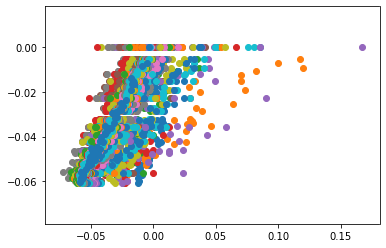

In [40]:
epoch,test_loader, model, criterion, normalizer = run()

Test: [0/1]	Time 0.033 (0.033)	Loss 1.4925 (1.4925)	MAE 1.493 (1.493)
 ** MAE 1.493


tensor(1.4925)

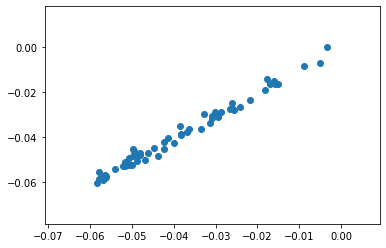

In [41]:
best_checkpoint = torch.load('model_final_submission.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])
validate(epoch,test_loader, model, criterion, normalizer, test=True)

In [42]:
import numpy as np

In [43]:
test_vals = np.loadtxt(open('test_results_final_submission.csv', "rb"), delimiter=",", usecols=(1,2))

In [44]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

[ 0 63 92]
[ 88  80 141]
[188  80 144]
[255  99  97]
[255 166   0]


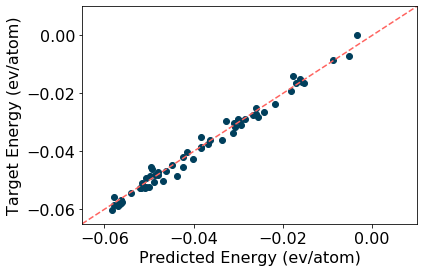

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Predicted Energy (ev/atom)',fontsize=16,fontname = "Arial")
plt.ylabel('Target Energy (ev/atom)',fontsize=16,fontname = "Arial")
plt.scatter(test_vals[:,1],test_vals[:,0],color=newcmp(0.0))
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.xlim(-0.065,0.01)
plt.ylim(-0.065,0.01)
x = np.linspace(-0.065,0.01,200)
plt.plot(x,x,color=newcmp(0.75),linestyle = '--')
plt.xticks([-0.06,-0.04,-0.02,0.0])
plt.yticks([-0.06,-0.04,-0.02,0.0])
plt.savefig('CGC_test_final_submission.pdf',bbox_inches='tight')
plt.show()

In [48]:
print(np.mean(np.abs(test_vals[:,0]-test_vals[:,1])))

0.001492532766273906


In [62]:
##### Recover Train,val,test

dataset_new = CIFData('data/Ag_Pd_root',radius = 12,max_num_nbr = 24)
collate_fn = collate_pool
train_loader_new, val_loader_new, test_loader_new = get_train_val_test_loader(
    dataset=dataset_new,
    collate_fn=collate_fn,
    batch_size=1,
    train_ratio=args.train_ratio,
    num_workers=args.workers,
    val_ratio=args.val_ratio,
    test_ratio=args.test_ratio,
    pin_memory=args.cuda,
    train_size=args.train_size,
    val_size=args.val_size,
    test_size=args.test_size,
    return_test=True)

In [100]:
train_id = {}
for i, (input, target, batch_cif_ids) in enumerate(train_loader_new):
    train_id[batch_cif_ids[0]] = 1

In [88]:
train_lst = list(train_id)

In [89]:
train_lst.sort()

In [101]:
val_id = {}
for i, (input, target, batch_cif_ids) in enumerate(val_loader_new):
    val_id[batch_cif_ids[0]] = 1


In [91]:
val_lst = list(val_id)

In [92]:
val_lst.sort()

In [102]:
test_id = {}
test_pred = []
test_act = []
for i, (input, target, batch_cif_ids) in enumerate(test_loader_new):
    test_id[batch_cif_ids[0]] = 1
    input_var = (Variable(input[0].cuda(non_blocking=True)),
                 Variable(input[1].cuda(non_blocking=True)),
                 input[2].cuda(non_blocking=True),
                 [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]])
    
    output = model(*input_var)
    
    test_pred.append(normalizer.denorm(output.data.cpu()))
    test_act.append(target)

In [94]:
test_pred = np.asarray(test_pred)
test_act = np.asarray(test_act)

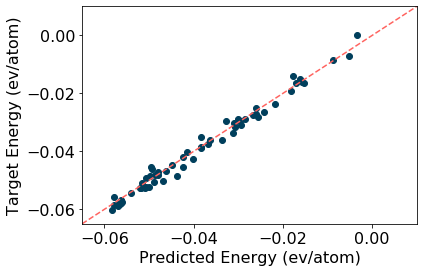

In [95]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Predicted Energy (ev/atom)',fontsize=16,fontname = "Arial")
plt.ylabel('Target Energy (ev/atom)',fontsize=16,fontname = "Arial")
plt.scatter(test_pred,test_act,color=newcmp(0.0))
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.xlim(-0.065,0.01)
plt.ylim(-0.065,0.01)
x = np.linspace(-0.065,0.01,200)
plt.plot(x,x,color=newcmp(0.75),linestyle = '--')
plt.xticks([-0.06,-0.04,-0.02,0.0])
plt.yticks([-0.06,-0.04,-0.02,0.0])
plt.show()

In [96]:
print(np.mean(np.abs(test_pred-test_act)))

0.0014925327


In [97]:
test_lst = list(test_id)

In [98]:
test_lst.sort()

In [99]:
import json

In [103]:
with open("train_ids_CGCNN.json", "w") as outfile:
    json.dump(train_id, outfile)
    
with open("val_ids_CGCNN.json", "w") as outfile:
    json.dump(val_id, outfile)

with open("test_ids_CGCNN.json", "w") as outfile:
    json.dump(test_id, outfile)

In [110]:
print(len(train_lst))

print(len(val_lst))

print(len(test_lst))

500
62
62
